In [1]:
'''Import packages'''
'''Requires numpy, pandas, scikit-learn, and matplotlib/seaborn'''
import numpy as np
import pandas as pd
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import Lasso
from scipy.stats import spearmanr

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")

'''Import script which contains functions'''
import analysis_functions
from analysis_functions import get_r2
from analysis_functions import get_lassoCV
from analysis_functions import perform_randomizedLasso

from IPython.display import display, HTML

#If we want to time the implementation: 
#import time
#start_time = time.time()

/home/prubbens/miniconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Import the dataframes: 

In [3]:
'''Import data'''
data_abs = pd.read_csv('data/Chloroplasts_removed/Nov2017_Filtering/5seqs_in_10percent_samples/nochloro_absolute_otu_5in10percent.tsv', sep=' ', index_col=None, header=0, float_precision='high')
data_rel = pd.read_csv('data/Chloroplasts_removed/Nov2017_Filtering/5seqs_in_10percent_samples/nochloro_relative_5in10percent.tsv', sep=' ', index_col=None, header=0, float_precision='high')
target = pd.read_csv('data/Chloroplasts_removed/Nov2017_Filtering/5seqs_in_10percent_samples/nochloro_HNA_LNA_5in10percent.tsv', sep= ' ', index_col=0, header=0)

**2)**: At 01-05-'17 @marschmi found that a few samples can be seen as outliers, as they represent the bottom waters of productive inland lakes, resulting in a big difference of the HNA percentage. These samples are the following: Z14055F, Z14003F, Z14007F, Z14023F, Z14011F. A code of line is added, in order to be able to run the pipeline without these samples; 

In [3]:
#samples_to_drop = ['Z14055F', 'Z14003F', 'Z14007F', 'Z14023F', 'Z14011F']
#index = target.index.drop(samples_to_drop)

In [4]:
'''Set sample names as index and shuffle data'''
index = data_rel.index

#Remove outlier samples:
data_abs = data_abs.loc[index,:] 
data_rel = data_rel.loc[index,:]
target = target.loc[index,:]
#productivity = productivity.loc[index,:]

#Shuffle data: 
data_abs = data_abs.sample(frac=1, random_state=3)
data_rel = data_rel.sample(frac=1, random_state=3)
target = target.sample(frac=1, random_state=3)
#productivity = productivity.sample(frac=1, random_state=3) 

#Create target columns of HNA-values: 
hna = target.loc[:,'HNA.cells']
hna_rel = hna/target.loc[:,'Total.cells']
hna = pd.Series(hna, index=hna.index)
hna_rel = pd.Series(hna_rel, index=hna.index)

#Create target columns of LNA-values: 
lna = target.loc[:,'LNA.cells']
lna_rel = lna/target.loc[:,'Total.cells']
lna = pd.Series(lna, index=lna.index)
lna_rel = pd.Series(lna_rel, index=lna.index)

In [5]:
#Some variables to store information and to create inner and outer CV-folds

#data_rel = data_rel.loc[:, (data_rel != 0).any(axis=0)]
otus = list(data_rel.columns)

#cv_out = 10
cv = 5
#outer_cv = KFold(n_splits=cv_out, shuffle=False)

#otu_scores_cv = pd.DataFrame(columns=otus)
#r2_cv = np.zeros(cv_out)
#thresholds_cv = np.zeros(cv_out)

#pred = pd.Series(index=data_abs.index)
#final_scores = pd.DataFrame(columns=otus)

#thresholds = np.arange(0,1,0.01)
#t = 0

In [6]:
''' Standardize data '''
from analysis_functions import standardize_df
data_stand, scaler = standardize_df(data_rel,otus)

To do so, we use the **_Randomized Lasso_**: this method makes use of two kinds of randomization in order to select variables (i.e., OTU's) with a certain _stability_: (1) it fits a Lasso to various bootstrap subsamples and (2) it perturbs the initial weighting of certain variables. 

This results in a $score \in [0,1]$ that is assigned to variables, with 0 denoting the case where a variable is never chosen by the Lasso, and 1 denoting the case where a variable always is chosen. In other words, the higher the score, the more important a variable can be considered to be. 

**First goal: ** try to pinpoint those OTU's for which we are sure they are present in the '_HNA-cloud_'. 

**Univariate Feature Selection**: 

Let's compare two methods: 
- f_regression (f-score pearson correlation), 
- Mutual information,  
- (other methods can follow as well). 

In [7]:
f_regr, f_regr_p = f_regression(data_stand.loc[:,otus],hna)
r_spearman = np.zeros(len(otus))
p_spearman = np.zeros(len(otus))
for i in np.arange(0,len(otus)):
    r_spearman[i], p_spearman[i] = spearmanr(data_stand.loc[:,otus[i]],hna, axis=0)
uni_fs = pd.DataFrame(f_regr, index=otus, columns = ['f_regr'])
uni_fs['p-value'] = f_regr_p
uni_fs['r_spearman'] = r_spearman
uni_fs['p_spearman'] = p_spearman
#uni_fs['mi'] = mutual_info_regression(data_stand.loc[:,otus],hna)
#uni_fs.sort_values(ascending=False,inplace=True, by='f_regr')
display(uni_fs.head(10))

,f_regr,p-value,r_spearman,p_spearman
Otu000001,97.366470,2.319832e-18,-0.628028,8.122354e-20
Otu000004,0.049420,8.243482e-01,-0.067880,3.819733e-01
Otu000005,14.303625,2.167901e-04,0.273147,3.405523e-04
Otu000006,1.665714,1.986283e-01,-0.224840,3.388422e-03
Otu000007,3.822219,5.225656e-02,-0.110076,1.554866e-01
Otu000009,1.065362,3.034970e-01,0.106238,1.704974e-01
Otu000010,5.354935,2.188923e-02,0.236413,2.033887e-03
Otu000011,5.461449,2.063436e-02,0.081045,2.963311e-01
Otu000012,0.621115,4.317572e-01,0.014637,8.506352e-01
Otu000016,0.180895,6.711565e-01,0.005008,9.486337e-01


In [8]:
uni_fs.to_csv('F_test_spearman_hna_5seq10.csv')

Select otu's based on $p < \text{thr}$: 

In [9]:
uni_fs_selected_f = uni_fs[uni_fs.loc[:,'p-value'].values < 0.05]
print('Number of selected OTUs using F-test with p < 0.05: ' + str(len(uni_fs_selected_f)))
uni_fs_selected_f = uni_fs[uni_fs.loc[:,'p-value'].values < 0.01]
print('Number of selected OTUs using F-test with p < 0.01: ' + str(len(uni_fs_selected_f)))
uni_fs_selected_f = uni_fs[uni_fs.loc[:,'p_spearman'].values < 0.05]
print('Number of selected OTUs using spearman correlation with p < 0.05: ' + str(len(uni_fs_selected_f)))
uni_fs_selected_f = uni_fs[uni_fs.loc[:,'p_spearman'].values < 0.01]
print('Number of selected OTUs using spearman correlation with p < 0.01: ' + str(len(uni_fs_selected_f)))

Number of selected OTUs using F-test with p < 0.05: 213
Number of selected OTUs using F-test with p < 0.01: 158
Number of selected OTUs using spearman correlation with p < 0.05: 330
Number of selected OTUs using spearman correlation with p < 0.01: 268


What happens when we tune a threshold in function of the f_score: 

In [10]:
from analysis_functions import get_r2_scores
thr_otu_f_regr_hna, r2_otu_f_regr_hna = get_r2_scores(data_stand.loc[:,otus], hna, otus, uni_fs['f_regr'], cv)
thr_otu_f_regr_lna, r2_otu_f_regr_lna = get_r2_scores(data_stand.loc[:,otus], lna, otus, uni_fs['f_regr'], cv)

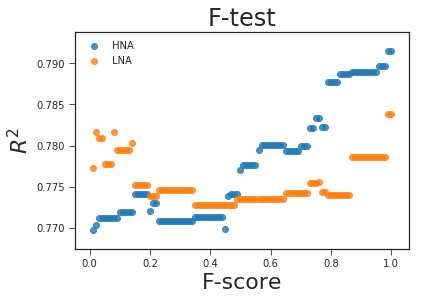

In [11]:
plt.figure()
sns.regplot(x=thr_otu_f_regr_hna,y=r2_otu_f_regr_hna, fit_reg=False, label='HNA')
sns.regplot(x=thr_otu_f_regr_lna,y=r2_otu_f_regr_lna, fit_reg=False, label='LNA')
plt.xlabel('F-score', size=22)
plt.xticks(size=10)
plt.ylabel(r'$R^2$', size=22)
plt.yticks(size=10)
plt.title('F-test', size=24)
plt.legend()
plt.show()

In [12]:
thr_otu_sp_hna, r2_otu_sp_hna = get_r2_scores(data_stand.loc[:,otus], hna, otus, np.absolute(uni_fs['r_spearman']), cv)
thr_otu_sp_lna, r2_otu_sp_lna = get_r2_scores(data_stand.loc[:,otus], lna, otus, np.absolute(uni_fs['r_spearman']), cv)

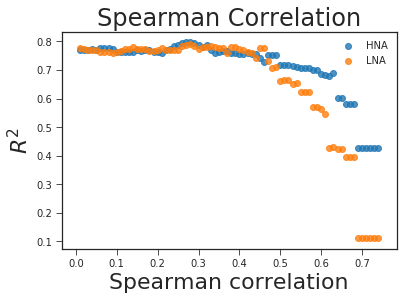

In [13]:
plt.figure()
sns.regplot(x=thr_otu_sp_hna,y=r2_otu_sp_hna, fit_reg=False, label='HNA')
sns.regplot(x=thr_otu_sp_lna,y=r2_otu_sp_lna, fit_reg=False, label='LNA')
plt.xlabel('Spearman correlation', size=22)
plt.xticks(size=10)
plt.ylabel(r'$R^2$', size=22)
plt.yticks(size=10)
plt.title('Spearman Correlation', size=24)
plt.legend()
plt.show()

In [14]:
#uni_fs.sort_values(ascending=False,inplace=True, by='mi')
#display(uni_fs.head(10))
#thr_otu_mi_hna, r2_otu_mi_hna = get_r2_scores(data_stand.loc[:,otus], hna, otus, uni_fs['mi'], cv)
#thr_otu_mi_lna, r2_otu_mi_lna = get_r2_scores(data_stand.loc[:,otus], lna, otus, uni_fs['mi'], cv)

In [15]:
#plt.figure()
#sns.regplot(x=thr_otu_mi_hna,y=r2_otu_mi_hna, fit_reg=False, label='HNA')
#sns.regplot(x=thr_otu_mi_lna,y=r2_otu_mi_lna, fit_reg=False, label='LNA')
#plt.xlabel('MI', size=22)
#plt.xticks(size=10)
#plt.ylabel(r'$R^2$', size=22)
#plt.yticks(size=10)
#plt.title('Mutual Information', size=24)
#plt.legend()
#plt.show()

In [16]:
from analysis_functions import get_lassoCV_alpha

alpha = get_lassoCV_alpha(data_stand.loc[:,otus],hna,otus,cv)
    
otu_scores = pd.DataFrame(perform_randomizedLasso(data_stand.loc[:,otus], hna, alpha), index=otus, columns=['score'])
otu_scores.sort_values(ascending=False,inplace=True, by='score')

thr_otu_scores_hna, r2_otu_scores_hna = get_r2_scores(data_stand.loc[:,otus], hna, otus, otu_scores, cv)
thr_otu_scores_lna, r2_otu_scores_lna = get_r2_scores(data_stand.loc[:,otus], lna, otus, otu_scores, cv)

/home/prubbens/miniconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


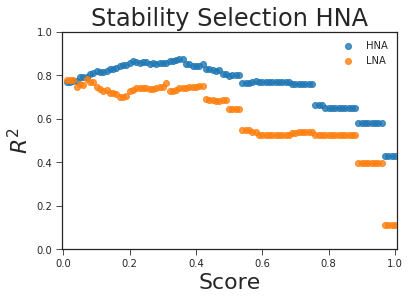

In [17]:
plt.figure()
sns.regplot(x=thr_otu_scores_hna,y=r2_otu_scores_hna, fit_reg=False, label='HNA')
sns.regplot(x=thr_otu_scores_lna,y=r2_otu_scores_lna, fit_reg=False, label='LNA')
plt.axis([-0.005,1.005,0,1])
plt.xlabel('Score', size=22)
plt.xticks(size=10)
plt.ylabel(r'$R^2$', size=22)
plt.yticks(size=10)
plt.legend()
plt.title('Stability Selection HNA', size=24)
plt.show()

In [18]:
r2_final = r2_otu_scores_hna.max()
thr = thr_otu_scores_hna[r2_otu_scores_hna.argmax()]
print('R²_cv(hna): ' + str(r2_final) )
print('Threshold score: ' + str(thr))

R²_cv(hna): 0.876142252643
Threshold score: 0.36


In [19]:
otu_scores = otu_scores.assign(abun_abs_mean = data_abs.loc[:,otus].mean())
otu_scores = otu_scores.assign(abun_abs_CV = data_abs.loc[:,otus].std()/data_abs.loc[:,otus].mean())
otu_scores =  otu_scores.assign(abun_rel_mean = data_rel.loc[:,otus].mean())
otu_scores = otu_scores.assign(abun_rel_CV = data_rel.loc[:,otus].std()/data_rel.loc[:,otus].mean())
otu_scores['r_spearman'] = uni_fs.loc[otu_scores.index,'r_spearman']
otu_scores['p_spearman'] = uni_fs.loc[otu_scores.index,'p_spearman']
otu_scores.to_csv('Final/hnascores_otus_5seq10_rel.csv')

In [20]:
otu_scores_selected = otu_scores[otu_scores.score.values>thr]
selected_otus = otu_scores_selected.index
otu_scores_selected.to_csv('Final/hnascores_otus_tuned_thr_'+str(thr)+'_5seq10_rel.csv')
display(otu_scores_selected.head(10))
print('Size list selected OTUs: ' + str(len(selected_otus)))

,score,abun_abs_mean,abun_abs_CV,abun_rel_mean,abun_rel_CV,r_spearman,p_spearman
Otu000173,0.996667,9202.636543,1.868851,0.001316,1.673870,0.731130,2.282389e-29
Otu000060,0.956667,27431.752891,1.430959,0.004059,1.039940,0.673595,1.460666e-23
Otu000313,0.873333,2917.175675,2.192946,0.000389,1.931977,0.481439,3.941161e-11
Otu000264,0.780000,4876.450423,3.555170,0.001022,3.016365,-0.084098,2.784446e-01
Otu000001,0.746667,388884.795943,0.710040,0.099741,0.624193,-0.628028,8.122354e-20
Otu000778,0.700000,1003.428651,3.139226,0.000126,2.437522,0.458778,3.996623e-10
Otu000682,0.676667,1400.166800,4.290562,0.000155,3.962109,0.269685,4.075465e-04
Otu000154,0.616667,4420.233668,1.423808,0.001512,2.476511,-0.146632,5.787481e-02
Otu000242,0.576667,5151.362021,3.267847,0.000738,2.498881,0.399873,7.873541e-08
Otu001038,0.570000,778.104645,2.538653,0.000162,2.600144,0.006431,9.340620e-01


Size list selected OTUs: 41


In [21]:
print('R²_cv of HNA-selected OTUs in function of LNA: ' + str(r2_otu_scores_lna[r2_otu_scores_hna.argmax()]) )

R²_cv of HNA-selected OTUs in function of LNA: 0.743252491511


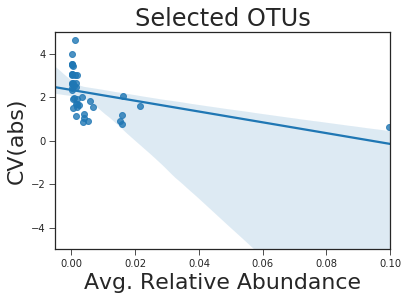

In [22]:
plt.figure()
sns.regplot(x='abun_rel_mean',y='abun_rel_CV', data=otu_scores_selected)
plt.axis([-0.005,0.1,-5,5])
plt.xlabel('Avg. Relative Abundance', size=22)
plt.xticks(size=10)
plt.ylabel('CV(abs)', size=22)
plt.yticks(size=10)
plt.title('Selected OTUs', size=24)
plt.show()

In [23]:
#optimal_scores.to_csv('HNA_selectedOTUs_stand_abun_remov' + str(abun)+'_R2'+str(r2_final)+'.csv')

**Second goal**: Can we use the same pipeline to predict the _LNA_-counts? 

In [24]:
f_regr_lna, f_regr_p_lna = f_regression(data_stand.loc[:,otus],lna)
uni_fs_lna = pd.DataFrame(f_regr_lna, index=otus, columns = ['f_regr'])
uni_fs_lna['p-value'] = f_regr_p_lna
r_spearman = np.zeros(len(otus))
p_spearman = np.zeros(len(otus))
for i in np.arange(0,len(otus)):
    r_spearman[i], p_spearman[i] = spearmanr(data_stand.loc[:,otus[i]],lna, axis=0)
uni_fs_lna = pd.DataFrame(f_regr_lna, index=otus, columns = ['f_regr'])
uni_fs_lna['p-value'] = f_regr_p
uni_fs_lna['r_spearman'] = r_spearman
uni_fs_lna['p_spearman'] = p_spearman
#uni_fs_lna['mi'] = mutual_info_regression(data_stand.loc[:,otus],lna)
#uni_fs_lna.sort_values(ascending=False,inplace=True, by='f_regr')
display(uni_fs_lna.head(10))

,f_regr,p-value,r_spearman,p_spearman
Otu000001,37.342575,2.319832e-18,-0.410897,3.159198e-08
Otu000004,0.206739,8.243482e-01,-0.052652,4.978869e-01
Otu000005,31.821503,2.167901e-04,0.511683,1.357356e-12
Otu000006,3.238010,1.986283e-01,-0.153684,4.670866e-02
Otu000007,2.086564,5.225656e-02,-0.057803,4.567295e-01
Otu000009,0.150741,3.034970e-01,0.006403,9.343447e-01
Otu000010,19.655594,2.188923e-02,0.388021,2.026947e-07
Otu000011,0.440603,2.063436e-02,0.009681,9.008828e-01
Otu000012,0.314627,4.317572e-01,0.108223,1.626051e-01
Otu000016,7.478735,6.711565e-01,0.221412,3.923025e-03


In [25]:
uni_fs_selected_f_lna = uni_fs_lna[uni_fs_lna.loc[:,'p-value'].values < 0.05]
print('Number of selected OTUs with p < 0.05: ' + str(len(uni_fs_selected_f_lna)))
uni_fs_selected_f_lna = uni_fs_lna[uni_fs_lna.loc[:,'p-value'].values < 0.01]
print('Number of selected OTUs with p < 0.01: ' + str(len(uni_fs_selected_f_lna)))
uni_fs_selected_f = uni_fs_lna[uni_fs_lna.loc[:,'p_spearman'].values < 0.05]
print('Number of selected OTUs using spearman correlation with p < 0.05: ' + str(len(uni_fs_selected_f)))
uni_fs_selected_f = uni_fs_lna[uni_fs_lna.loc[:,'p_spearman'].values < 0.01]
print('Number of selected OTUs using spearman correlation with p < 0.01: ' + str(len(uni_fs_selected_f)))

Number of selected OTUs with p < 0.05: 213
Number of selected OTUs with p < 0.01: 158
Number of selected OTUs using spearman correlation with p < 0.05: 354
Number of selected OTUs using spearman correlation with p < 0.01: 308


In [26]:
uni_fs.to_csv('F_test_spearman_lna_5seq10.csv')

In [27]:
thr_otu_f_regr_lna, r2_otu_f_regr_lna = get_r2_scores(data_stand.loc[:,otus], lna, otus, uni_fs_lna['f_regr'], cv)
thr_otu_f_regr_hna, r2_otu_f_regr_hna = get_r2_scores(data_stand.loc[:,otus], hna, otus, uni_fs_lna['f_regr'], cv)

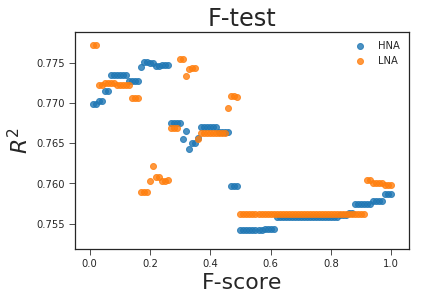

In [28]:
plt.figure()
sns.regplot(x=thr_otu_f_regr_hna,y=r2_otu_f_regr_hna, fit_reg=False, label='HNA')
sns.regplot(x=thr_otu_f_regr_lna,y=r2_otu_f_regr_lna, fit_reg=False, label='LNA')
#plt.axis([-0.5,140,0,1])
plt.xlabel('F-score', size=22)
plt.xticks(size=10)
plt.ylabel(r'$R^2$', size=22)
plt.yticks(size=10)
plt.title('F-test', size=24)
plt.legend()
plt.show()

In [29]:
thr_otu_sp_lna, r2_otu_sp_lna = get_r2_scores(data_stand.loc[:,otus], lna, otus, np.absolute(uni_fs_lna['r_spearman']), cv)
thr_otu_sp_hna, r2_otu_sp_hna = get_r2_scores(data_stand.loc[:,otus], hna, otus, np.absolute(uni_fs_lna['r_spearman']), cv)

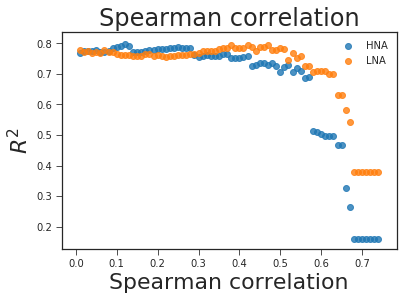

In [30]:
plt.figure()
sns.regplot(x=thr_otu_sp_hna,y=r2_otu_sp_hna, fit_reg=False, label='HNA')
sns.regplot(x=thr_otu_sp_lna,y=r2_otu_sp_lna, fit_reg=False, label='LNA')
plt.xlabel('Spearman correlation', size=22)
plt.xticks(size=10)
plt.ylabel(r'$R^2$', size=22)
plt.yticks(size=10)
plt.title('Spearman correlation', size=24)
plt.legend()
plt.show()

In [31]:
alpha = get_lassoCV_alpha(data_stand.loc[:,otus],lna,otus,cv)
otu_scores_lna = pd.DataFrame(perform_randomizedLasso(data_stand.loc[:,otus], lna, alpha), index=otus, columns=['score'])
otu_scores_lna.sort_values(ascending=False, inplace=True, by='score')

thr_otu_scores_lna, r2_otu_scores_lna = get_r2_scores(data_stand.loc[:,otus], lna, otus, otu_scores_lna, cv)
thr_otu_scores_hna, r2_otu_scores_hna = get_r2_scores(data_stand.loc[:,otus], hna, otus, otu_scores_lna, cv)

/home/prubbens/miniconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


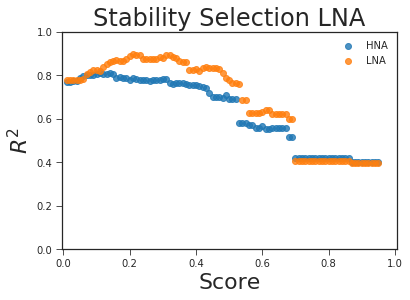

In [32]:
plt.figure()
sns.regplot(x=thr_otu_scores_hna,y=r2_otu_scores_hna, fit_reg=False, label='HNA')
sns.regplot(x=thr_otu_scores_lna,y=r2_otu_scores_lna, fit_reg=False, label='LNA')
plt.axis([-0.005,1.005,0,1])
plt.xlabel('Score', size=22)
plt.xticks(size=10)
plt.ylabel(r'$R^2$', size=22)
plt.yticks(size=10)
plt.legend()
plt.title('Stability Selection LNA', size=24)
plt.show()

In [33]:
r2_final = r2_otu_scores_lna.max()
thr_lna = thr_otu_scores_lna[r2_otu_scores_lna.argmax()]
print('R²_cv(lna): ' + str(r2_final) )
print('Threshold score: ' + str(thr_lna))

R²_cv(lna): 0.898148489693
Threshold score: 0.21


In [34]:
otu_scores_lna = otu_scores_lna.assign(abun_abs_mean = data_abs.loc[:,otus].mean())
otu_scores_lna = otu_scores_lna.assign(abun_abs_CV = data_abs.loc[:,otus].std()/data_abs.loc[:,otus].mean())
otu_scores_lna =  otu_scores_lna.assign(abun_rel_mean = data_rel.loc[:,otus].mean())
otu_scores_lna = otu_scores_lna.assign(abun_rel_CV = data_rel.loc[:,otus].std()/data_rel.loc[:,otus].mean())
otu_scores_lna['r_spearman'] = uni_fs_lna.loc[otu_scores.index,'r_spearman']
otu_scores_lna['p_spearman'] = uni_fs_lna.loc[otu_scores.index,'p_spearman']
otu_scores_lna.to_csv('Final/lnascores_otus_abun_5seq10_rel.csv')


In [35]:
otu_scores_selected_lna = otu_scores_lna[otu_scores_lna.score.values>thr_lna]
selected_otus_lna = otu_scores_selected_lna.index
print('Size list selected OTUs: ' + str(len(selected_otus_lna)))
otu_scores_selected_lna.to_csv('Final/lnascores_otus_tuned_thr_'+str(thr_lna)+'_5seq10_rel.csv')
display(otu_scores_selected_lna.head(10))

Size list selected OTUs: 124


,score,abun_abs_mean,abun_abs_CV,abun_rel_mean,abun_rel_CV,r_spearman,p_spearman
Otu000060,0.943333,27431.752891,1.430959,0.004059,1.039940,0.648102,2.179552e-21
Otu000287,0.853333,6997.545419,4.951683,0.001314,4.287124,-0.004307,9.558168e-01
Otu000075,0.690000,19069.997115,1.299822,0.006643,1.559337,-0.411438,3.018197e-08
Otu000113,0.683333,6981.672822,2.487085,0.000863,2.390282,0.620166,3.122007e-19
Otu000313,0.670000,2917.175675,2.192946,0.000389,1.931977,0.565128,1.463504e-15
Otu000117,0.620000,1316.683259,3.842288,0.000220,3.069271,0.034831,6.539881e-01
Otu000024,0.593333,85415.949950,1.128066,0.015264,0.885935,0.401307,7.004854e-08
Otu000279,0.586667,4272.285756,4.426146,0.000644,2.633250,0.343739,5.069455e-06
Otu000335,0.563333,6536.720753,2.369310,0.000949,1.952866,0.421826,1.235917e-08
Otu000074,0.550000,13440.587905,0.795363,0.003679,0.856972,-0.524377,2.981901e-13


In [36]:
print('R²_cv of LNA-selected OTUs in function of HNA: ' + str(r2_otu_scores_hna[r2_otu_scores_lna.argmax()]) )

R²_cv of LNA-selected OTUs in function of HNA: 0.786911782058


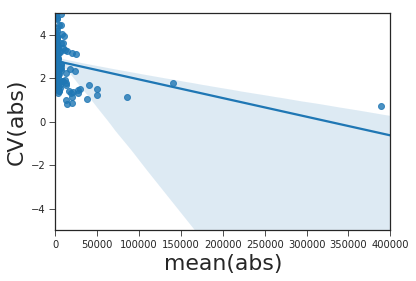

In [37]:
plt.figure()
sns.regplot(x='abun_abs_mean',y='abun_abs_CV', data=otu_scores_selected_lna)
plt.axis([0,400000,-5,5])
plt.xlabel('mean(abs)', size=22)
plt.xticks(size=10)
plt.ylabel('CV(abs)', size=22)
plt.yticks(size=10)
plt.show()

Let's compare the HNA- and LNA-lists, which OTU's are shared (_common_) and which are only part of the HNA- or LNA subset?: 

In [38]:
idx_hna = otu_scores_selected.index.difference(otu_scores_selected_lna.index)
idx_lna = otu_scores_selected_lna.index.difference(otu_scores_selected.index)
idx_common = otu_scores_selected.drop(idx_hna).index
pd.Series(idx_common).to_csv('commonOTU_HNALNA_rel.csv')
print('Size subset OTUs only related to HNA: ' + str(len(idx_hna)) + '; opposed to total size: ' + str(len(otu_scores_selected)))
print('Size subset OTUs only related to LNA: ' + str(len(idx_lna)) + '; opposed to total size: ' + str(len(otu_scores_selected_lna)))
print('Size subset OTUs related to both: ' + str(len(idx_common)))

display(otu_scores_selected_lna.loc[idx_common,:])
#data_abs_raw = pd.read_csv('data/Chloroplasts_removed/nochloro_absolute_otu.tsv', sep=' ', index_col=None, header=0)
#data_abs_raw = data_abs_raw.loc[index,:]
#display(data_abs_raw.loc[:,idx_hna].sum(axis=1).values/hna.values)

Size subset OTUs only related to HNA: 12; opposed to total size: 41
Size subset OTUs only related to LNA: 95; opposed to total size: 124
Size subset OTUs related to both: 29


,score,abun_abs_mean,abun_abs_CV,abun_rel_mean,abun_rel_CV,r_spearman,p_spearman
Otu000173,0.516667,9202.636543,1.868851,0.001316,1.673870,0.566720,1.171190e-15
Otu000060,0.943333,27431.752891,1.430959,0.004059,1.039940,0.648102,2.179552e-21
Otu000313,0.670000,2917.175675,2.192946,0.000389,1.931977,0.565128,1.463504e-15
Otu000001,0.310000,388884.795943,0.710040,0.099741,0.624193,-0.410897,3.159198e-08
Otu000778,0.330000,1003.428651,3.139226,0.000126,2.437522,0.459711,3.645090e-10
Otu000682,0.486667,1400.166800,4.290562,0.000155,3.962109,0.368701,8.761093e-07
Otu000154,0.433333,4420.233668,1.423808,0.001512,2.476511,-0.040679,6.005994e-01
Otu000242,0.336667,5151.362021,3.267847,0.000738,2.498881,0.288282,1.509930e-04
Otu001038,0.523333,778.104645,2.538653,0.000162,2.600144,0.083276,2.831865e-01
Otu000335,0.563333,6536.720753,2.369310,0.000949,1.952866,0.421826,1.235917e-08


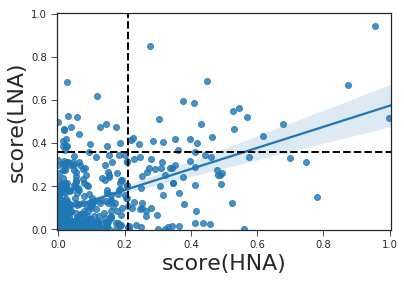

In [39]:
plt.figure()
sns.regplot(x=otu_scores.loc[:,'score'],y=otu_scores_lna.loc[otu_scores.index,'score'])
plt.axis([-0.005,1.005,-0.005,1.005])
plt.xlabel('score(HNA)', size=22)
plt.xticks(size=10)
plt.ylabel('score(LNA)', size=22)
plt.yticks(size=10)
plt.axhline(y=thr, linewidth=2, linestyle='--', color = 'k')
plt.axvline(x=thr_lna, linewidth=2, linestyle='--', color = 'k')
plt.show()

This figure shows 4 area's: 
- (left top corner): OTU's selected solely in function of **LNA**-dynamics, 
- (right top corner): OTU's selected in function of both **HNA**- and **LNA**-dynamics, 
- (left bottom corner): OTU's that are _not_ selected, 
- (right bottom corner): OTU's selected solely in function of **HNA**-dynamics. 

Univariate vs. Stability selection

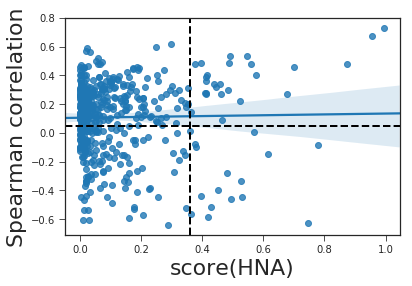

In [40]:
plt.figure()
sns.regplot(x=otu_scores.loc[:,'score'],y=uni_fs.loc[otu_scores.index,'r_spearman'])
plt.xlabel('score(HNA)', size=22)
plt.xticks(size=10)
plt.ylabel('Spearman correlation', size=22)
plt.yticks(size=10)
#plt.yscale('log')
plt.axhline(y=0.05, linewidth=2, linestyle='--', color = 'k')
plt.axvline(x=thr, linewidth=2, linestyle='--', color = 'k')
#plt.axis([-0.005,1.005,0.0000000000000000000001, 1])
plt.show()

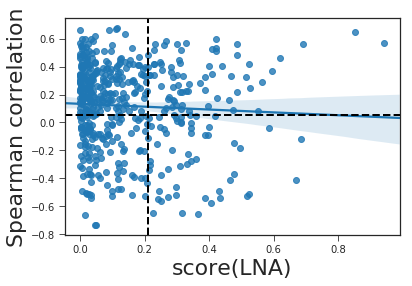

In [41]:
plt.figure()
sns.regplot(x=otu_scores_lna.loc[:,'score'],y=uni_fs_lna.loc[otu_scores.index,'r_spearman'])
plt.xlabel('score(LNA)', size=22)
plt.xticks(size=10)
plt.ylabel('Spearman correlation', size=22)
plt.yticks(size=10)
#plt.yscale('log')
plt.axhline(y=0.05, linewidth=2, linestyle='--', color = 'k')
plt.axvline(x=thr_lna, linewidth=2, linestyle='--', color = 'k')
#plt.axis([-0.005,1.005,0.0000000000000000000001, 1])
plt.show()

This analysis shows that the HNA/LNA dynamics cannot solely be attributed to OTU's that are present in the respective cloud; this is also clear from the mutual correlation between HNA- and LNA-counts ( $\rho(\text{HNA,LNA}) = 0.75$ ). 

I see two reasons for this: 
- Some OTU's are simply present in the two clouds; 
- Some HNA-OTU's interact with LNA-OTU's and vice versa. 